In [4]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, TensorBoard
import keras.backend as K

In [5]:
# Creating dataframes
same_pairs = pd.read_csv("same_pairs.csv")
diffn_pairs = pd.read_csv("diffn_pairs.csv")
features = pd.read_csv("HumanObserved-Features-Data.csv")

# reading GSC data
gsc_same = pd.read_csv("gsc_same_pairs.csv")
gsc_diffn = pd.read_csv("gsc_diffn_pairs.csv")
gsc_features = pd.read_csv("gsc-Features.csv")

In [6]:
############## Human Observed Datasets - Removing Duplicates ######################
# creating unique Author/Writer dataset for same_pairs
split_s = same_pairs['img_id_A'].str.split('(\d+)([a-z]+)', expand = True) # splitting to get writer ids
split_s = split_s.loc[:, [1,2]]
split_s.rename(columns={1: 'author', 2:'img'}, inplace = True)
# print(split_s)
same_pairs = pd.concat([same_pairs,split_s], axis = 1)
same_pairs.drop_duplicates(subset='author', keep='first', inplace=True) #dropping duplicate writer images
same_pairs = same_pairs.drop(['author', 'img'], axis = 1)
# print(same_pairs)
print(same_pairs.shape)

# creating unique Author/Writer dataset for diffn_pairs
split_d = diffn_pairs['img_id_A'].str.split('(\d+)([a-z]+)', expand = True)
split_d = split_d.loc[:, [1,2]]
split_d.rename(columns={1: 'author', 2:'img'}, inplace = True)
diffn_pairs = pd.concat([diffn_pairs,split_d], axis = 1)
diffn_pairs.drop_duplicates(subset='author', keep='first', inplace=True)
diffn_pairs = diffn_pairs.drop(['author', 'img'], axis = 1)
# print(diffn_pairs)
print(diffn_pairs.shape)

############## GSC Datasets - Removing Duplicates ########################
# creating unique Author/Writer dataset for same_pairs
gsc_split_same = gsc_same['img_id_A'].str.split('(\d+)([a-z]+)', expand = True)
gsc_split_same = gsc_split_same.loc[:, [1,2]]
gsc_split_same.rename(columns={1: 'author', 2:'img'}, inplace = True)
gsc_same = pd.concat([gsc_same, gsc_split_same], axis = 1)
gsc_same.drop_duplicates(subset='author', keep='first', inplace=True)
gsc_same = gsc_same.drop(['author', 'img'], axis = 1)
# print(gsc_same)
print(gsc_same.shape)

# creating unique Author/Writer dataset for diffn_pairs
gsc_split_diffn = gsc_diffn['img_id_A'].str.split('(\d+)([a-z]+)', expand = True)
gsc_split_diffn = gsc_split_diffn.loc[:, [1,2]]
gsc_split_diffn.rename(columns={1: 'author', 2:'img'}, inplace = True)
gsc_diffn = pd.concat([gsc_diffn, gsc_split_diffn], axis = 1)
gsc_diffn.drop_duplicates(subset='author', keep='first', inplace=True)
gsc_diffn = gsc_diffn.drop(['author', 'img'], axis = 1)
# print(gsc_diffn)
print(gsc_diffn.shape)

(340, 3)
(462, 3)
(1489, 3)
(1532, 3)


In [7]:
print("Number of unique same writer pairs in Human Observed Dataset:")
print(same_pairs.shape)
print("\nNumber of unique different wirter pairs in Human Observed Dataset:")
print(diffn_pairs.shape)

print("\nNumber of unique same writer pairs in GSC:")
print(gsc_same.shape)
print("\nNumber of unique different wirter pairs in GSC:")
print(gsc_diffn.shape)
#gsc_diffn.img_id_A.str[:4]

Number of unique same writer pairs in Human Observed Dataset:
(340, 3)

Number of unique different wirter pairs in Human Observed Dataset:
(462, 3)

Number of unique same writer pairs in GSC:
(1489, 3)

Number of unique different wirter pairs in GSC:
(1532, 3)


## FEATURE CONCATENATION

In [8]:
################### HUMAN OBSERVED DATASET #######################
# concatinating same_pairs and diffn_pairs
combined_pairs = pd.concat([same_pairs, diffn_pairs], join = 'inner', ignore_index = True)
concat1 = pd.merge(combined_pairs, features, how = 'inner', left_on = 'img_id_A', right_on = 'img_id') # adding features of img_id_A
concat2 = pd.merge(concat1, features, how = 'inner', left_on = 'img_id_B', right_on = 'img_id') # adding features of 'img_id_B' from 'features' dataframe
human_concat = concat2.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'img_id_x', 'img_id_y'], axis = 1) #dropping unnecessary columns

# re-ordering the columns
cols = list(human_concat) # creating a list of columns
cols.insert(21, cols.pop(cols.index('target'))) # moving the 'target' column to the end
human_concat = human_concat.loc[:, cols]

# randomising the rows and using a random_state to maintain a state
human_concat = human_concat.sample(frac=1, random_state=121).reset_index(drop = True)
print("\nShape of Human Observed Dataset With Feature Concatenation is:")
print(human_concat.shape)

################ GSC DATASET #######################
# concatinating GSC pairs
gsc_combined_pairs = pd.concat([gsc_same, gsc_diffn], join = 'inner', ignore_index = True)
gsc_concat1 = pd.merge(gsc_combined_pairs, gsc_features, how = 'inner', left_on = 'img_id_A', right_on = 'img_id')
gsc_concat2 = pd.merge(gsc_concat1, gsc_features, how = 'inner', left_on = 'img_id_B', right_on = 'img_id')
gsc_concat = gsc_concat2.drop([ 'img_id_x', 'img_id_y'], axis = 1)

# re-ordering the columns
cols = list(gsc_concat) # creating a list of columns
cols.insert(1027, cols.pop(cols.index('target'))) # moving the 'target' column to the end
gsc_concat = gsc_concat.loc[:, cols]

# randomising the rows and using a random_state to maintain a state
gsc_concat = gsc_concat.sample(frac=1, random_state=121).reset_index(drop = True)

print("\n Shape of GSC Dataset With Feature Concatenation is:")
print(gsc_concat.shape)


Shape of Human Observed Dataset With Feature Concatenation is:
(802, 21)

 Shape of GSC Dataset With Feature Concatenation is:
(3021, 1027)


## FEATURE SUBTRACTION

In [9]:
#################### Creating Human Observed Dataset with Feature Subtraction ######################
human_sub = human_concat[['img_id_A', 'img_id_B']].copy()
human_sub['f1'] = (human_concat['f1_x'] - human_concat['f1_y']).abs()
human_sub['f2'] = (human_concat['f2_x'] - human_concat['f2_y']).abs()
human_sub['f3'] = (human_concat['f3_x'] - human_concat['f3_y']).abs()
human_sub['f4'] = (human_concat['f4_x'] - human_concat['f4_y']).abs()
human_sub['f5'] = (human_concat['f5_x'] - human_concat['f5_y']).abs()
human_sub['f6'] = (human_concat['f6_x'] - human_concat['f6_y']).abs()
human_sub['f7'] = (human_concat['f7_x'] - human_concat['f7_y']).abs()
human_sub['f8'] = (human_concat['f8_x'] - human_concat['f8_y']).abs()
human_sub['f9'] = (human_concat['f9_x'] - human_concat['f9_y']).abs()
human_sub['target'] = human_concat[['target']].copy()

print("\nShape of Human Observed Dataset With Feature Subtraction is:")
print(human_sub.shape)

####################### Creating GSC Dataset with Feature Subtraction ###########################
gsc_sub = gsc_concat[['img_id_A', 'img_id_B']].copy()
for i in range(1, 513):
    gsc_sub['f'+str(i)] = (gsc_concat['f'+ str(i) + '_x'] - gsc_concat['f' + str(i) + '_y']).abs()
    gsc_sub['f'+str(i)] += 1
gsc_sub['target'] = gsc_concat[['target']].copy()

print("\n Shape of GSC Dataset With Feature Subtraction is:")
print(gsc_sub.shape)


Shape of Human Observed Dataset With Feature Subtraction is:
(802, 12)

 Shape of GSC Dataset With Feature Subtraction is:
(3021, 515)


In [10]:
human_sub_f = human_sub.loc[:,'f1':'f9']
human_sub_f_dirty = human_sub_f + 0.00001*np.random.rand(802, 9)
human_sub.to_csv('human_sub_t.csv', columns = ['target'], header = False, index = False)
human_sub_f_dirty.to_csv('human_sub_X.csv', columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'], header = False, index = False)

In [11]:
human_concat_f = human_concat.loc[:, 'f1_x':'f9_y']
human_concat_f_dirty = human_concat_f + 0.00001*np.random.rand(802, 18)
human_concat.to_csv('human_concat_t.csv', columns = ['target'], header = False, index = False)
human_concat_f_dirty.to_csv('human_concat_X.csv', columns = ['f1_x', 'f2_x', 'f3_x', 'f4_x', 'f5_x', 'f6_x', 'f7_x', 'f8_x', 'f9_x', 'f1_y', 'f2_y', 'f3_y', 'f4_y', 'f5_y', 'f6_y', 'f7_y', 'f8_y', 'f9_y'], header = False, index = False)

In [12]:
gsc_sub_f = gsc_sub.loc[:,'f1':'f512']
gsc_sub_f_dirty = gsc_sub_f + 0.00001*np.random.rand(3021, 512)
gsc_sub.to_csv('gsc_sub_t.csv', columns = ['target'], header = False, index = False)
gsc_sub_f_dirty.to_csv('gsc_sub_X.csv', columns = gsc_sub_f_dirty.loc[:,'f1':'f512'], header = False, index = False)

In [13]:
gsc_concat_f = gsc_concat.loc[:, 'f1_x':'f512_y']
gsc_concat_f_dirty = gsc_concat_f + 0.00001*np.random.rand(3021, 1024)
gsc_concat.to_csv('gsc_concat_t.csv', columns = ['target'], header = False, index = False)
gsc_concat_f_dirty.to_csv('gsc_concat_X.csv', columns = gsc_concat_f_dirty.loc[:, 'f1_x':'f512_y'], header = False, index = False)

## Gradient Descent Functions

In [14]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.000005
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
n = 200 #multiplication factor in BigSigma i.e., in np.dot(n, BigSigma)
IsSynthetic = False

In [15]:
# Creating a List of all the Target Values
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'r') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    return t

# creating target values list for Training data. Training Data set to 80% of the total data 
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01))) #from rawtarget which is a list of length of around 69,000
    t           = rawTraining[:TrainingLen] #will slice the list the integer value of TrainingLen
    return t

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize #end point of validation data
    t =rawData[TrainingCount+1:V_End] #slicing to get the validation set target samples
    return t

# Creating data matrix from the specified csv file
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'r') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow) 

    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

# Generating Training data (80% of Total samples)
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent)) #to determine the number of rows/samples in training data
    d2 = rawData[:,0:T_len] #slicing to get training data samples
    return d2

# Generating Validation data (10% of the data)
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01)) #10%
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End] 
    return dataMatrix

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))#(41)
    DataT       = np.transpose(Data)#60k*41
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))#60k*0.8=55k        
    varVect     = []
    for i in range(0,len(DataT[0])):#41
        vct = []
        for j in range(0,int(TrainingLen)):#50k
            vct.append(Data[i][j])    #1*50k:This is list that contains all the input in particular features
        varVect.append(np.var(vct))#41*41:Calculating variance here of features

    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]#Removing co variance thats is variance between different features
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(n,BigSigma) #multiply with different values and see the effect on erms. We are increasing the value of variance
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow) # (x-mean)
    T = np.dot(BigSigInv,np.transpose(R)) # transpose of (x-mean) * inverse of variance matrix
    L = np.dot(R,T) #  (x-mean) * inverse of variance matrix * transpose of (x-mean)
    return L

# calculating a single feature value
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# generating the PHI/Feature matrix
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) #defining PHI matrix with zeros and dimensions = Training data samples x No. of clusters/basis fn.
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)): #for a particular column of the M features
        for R in range(0,int(TrainingLen)): # for each row
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) #generating the FEATURE/PHI matrix
    #print ("PHI Generated..")
    return PHI


# finding/generating weights using Moore-Penrose pseudo inverse method including regularization
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0])) # identity matrix of 10*10
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda #creating identity matrix with lambda values
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR) #adding regularizer
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI) # calculating the multiplicative inverse
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

# predicting the target value
def GetValTest(VAL_PHI,W):
    Y = np.dot(VAL_PHI, W)
    ##print ("Test Out Generated..")
    return Y


# finding Root Mean Square error and Accuracy
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2) #summation of (Actual target - predicted target)^2
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]): #rounding the predicted target values to values with no decimal points and comparing with the actual target value
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Logistic Regression Functions

In [16]:
def sigmoid(VAL_TEST_OUT):
    S = 1.0/(1.0 + np.exp(-VAL_TEST_OUT))
    return S


# predicting the target value
def LogPred(VAL_PHI,W):
    Y = np.dot(VAL_PHI, W)
    Z = sigmoid(Y) #taking sigmoid of the linear prediction
    return Z 

# finding Root Mean Square error and Accuracy
def LogGetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum - (np.dot(ValDataAct[i], np.log(VAL_TEST_OUT[i]))) - (np.dot((1-ValDataAct[i]), np.log(1-VAL_TEST_OUT[i]))) #math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2) #summation of (Actual target - predicted target)^2
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]): #rounding the predicted target values to values with no decimal points and comparing with the actual target value
            counter+=100
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    return (str(accuracy) + ',' +  str(sum/len(VAL_TEST_OUT))) #no need of square root here. This is the average cost/cross-entropy

## 1. HUMAN OBSERVED DATASET WITH FEATURE SUBTRACTION

In [17]:
### Fetch and Prepare Datasets
RawTarget = GetTargetVector('human_sub_t.csv')
RawData   = GenerateRawData('human_sub_X.csv',IsSynthetic)

### Prepare Training Data
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

### Prepare Validation Data
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

### Prepare Test Data
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)

(642,)
(9, 642)
(80,)
(9, 80)
(79,)
(9, 79)


### 1A. Linear Regression with Gradient Descent (Human Feature Subtraction)

In [18]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [19]:
print ('----------Gradient Descent Solution--------------------')
print ("M = " + str(M))
print("Lambda = " + str(La/np.subtract(xn, x1))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 10
Lambda = 0.0390625
eta = 0.01
E_rms Training   = 0.49833
E_rms Validation = 0.48687
E_rms Testing    = 0.47466


### 1B. Logistic Regression With Gradient Descent (Human Feature Subtraction)

In [20]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    #Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    Delta_E_D     = -np.dot((TrainingTarget[i] - sigmoid(np.dot(np.transpose(W_Now), TRAINING_PHI[i]))), TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = LogPred(TRAINING_PHI,W_T_Next) 
    Erms_TR       = LogGetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = LogPred(VAL_PHI,W_T_Next) 
    Erms_Val      = LogGetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = LogPred(TEST_PHI,W_T_Next) 
    Erms_Test = LogGetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [21]:
print ('----------Logistic Regression using Stochastic Gradient Descent--------------------')
print ("M = " + str(M))
print("Lambda = " + str(np.around((La/np.subtract(xn, x1)), decimals = 5))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("Cross-Entropy Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Cross-Entropy Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Cross-Entropy Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Logistic Regression using Stochastic Gradient Descent--------------------
M = 10
Lambda = 0.03906
eta = 0.01
Cross-Entropy Training   = 0.68528
Cross-Entropy Validation = 0.67299
Cross-Entropy Testing    = 0.66143


### 1C. Neural Network Implementation (Human Feature Subtraction)

In [22]:
# Human Observed Dataset with Subtraction
hs = human_sub.drop(['img_id_A', 'img_id_B'], axis = 1)

train, test = train_test_split(hs, test_size=0.1) #splitting to training and testing data

# Training Data
hs_train_target = train['target']
hs_train_features = train.drop(['target'], axis = 1)

# Testing Data
hs_test_target = test['target']
hs_test_features = test.drop(['target'], axis = 1)

print("hs_train_target shape is: " + str(hs_train_target.shape))
print("hs_train_features shape is: " + str(hs_train_features.shape))
print("hs_test_target shape is: " + str(hs_test_target.shape))
print("hs_test_features shape is: " + str(hs_test_features.shape))

hs_train_target shape is: (721,)
hs_train_features shape is: (721, 9)
hs_test_target shape is: (81,)
hs_test_features shape is: (81, 9)


In [25]:
K.clear_session()
model = Sequential()
model.add(Dense(256, input_dim = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('RMSprop', 'binary_crossentropy', metrics = ['accuracy'])

# earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=0, patience=300, mode='max')

history = model.fit(hs_train_features, hs_train_target,
                    validation_split = 0.1,
                    batch_size = 256,
                    epochs = 500,
                    verbose = 0)

In [ ]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

#### Evaluation

In [26]:
scores = model.evaluate(hs_test_features, hs_test_target)
# scores[1]
print("\nBinary Crossentropy %s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

81/81 [==============================] - 0s 118us/step

Binary Crossentropy loss: 70.91%

acc: 56.79%


### 2. HUMAN OBSERVED DATASET WITH FEATURE CONCATENATION

In [554]:
RawTarget = GetTargetVector('human_concat_t.csv')
RawData   = GenerateRawData('human_concat_X.csv',IsSynthetic)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(642,)
(18, 642)
(80,)
(18, 80)
(80,)
(18, 80)


### 2A. Linear Regression with Gradient Descent (Human Feature Concatenation)


In [439]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [440]:
print ('----------Gradient Descent Solution--------------------')
print ("M = " + str(M))
print("Lambda = " + str(La/np.subtract(xn, x1))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 10
Lambda = 0.0390625
eta = 0.01
E_rms Training   = 0.49934
E_rms Validation = 0.48659
E_rms Testing    = 0.47387


### 2B. Logistic Regression with Gradient Descent (Human Feature Concatenation)

In [555]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - sigmoid(np.dot(np.transpose(W_Now), TRAINING_PHI[i]))), TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = LogPred(TRAINING_PHI,W_T_Next) 
    Erms_TR       = LogGetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = LogPred(VAL_PHI,W_T_Next) 
    Erms_Val      = LogGetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = LogPred(TEST_PHI,W_T_Next) 
    Erms_Test = LogGetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [556]:
print ('----------Logistic Regression using Stochastic Gradient Descent--------------------')
print ("M = " + str(M))
print("Lambda = " + str(np.around((La/np.subtract(xn, x1)), decimals = 5))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("Cross-Entropy Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Cross-Entropy Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Cross-Entropy Testing    = " + str(np.around(min(L_Erms_Test),5)))
print()

----------Logistic Regression using Stochastic Gradient Descent--------------------
M = 10
Lambda = 0.03906
eta = 0.01
Cross-Entropy Training   = 0.68537
Cross-Entropy Validation = 0.67364
Cross-Entropy Testing    = 0.66276



### 2C. Neural Network Implementation (Human Feature Concatenation)

In [27]:
# Human Observed Dataset with Subtraction
hc = human_concat.drop(['img_id_A', 'img_id_B'], axis = 1)

train, test = train_test_split(hc, test_size=0.1) #splitting to training and testing data

# Training Data
hc_train_target = train['target']
hc_train_features = train.drop(['target'], axis = 1)

# Testing Data
hc_test_target = test['target']
hc_test_features = test.drop(['target'], axis = 1)

print("hc_train_target shape is: " + str(hc_train_target.shape))
print("hc_train_features shape is: " + str(hc_train_features.shape))
print("hc_test_target shape is: " + str(hc_test_target.shape))
print("hc_test_features shape is: " + str(hc_test_features.shape))

hc_train_target shape is: (721,)
hc_train_features shape is: (721, 18)
hc_test_target shape is: (81,)
hc_test_features shape is: (81, 18)


In [30]:
K.clear_session()
model = Sequential()
model.add(Dense(256, input_dim = 18, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('RMSprop', 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(hc_train_features, hc_train_target,
                    validation_split = 0.1,
                    batch_size = 256,
                    epochs = 500,
                    verbose = 0)

In [ ]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

#### Evaluation

In [31]:
scores = model.evaluate(hc_test_features, hc_test_target)
# scores[1]
print("\nBinary Crossentropy %s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

81/81 [==============================] - 0s 36us/step

Binary Crossentropy loss: 86.07%

acc: 51.85%


### 3. GSC DATASET WITH FEATURE SUBTRACTION

In [557]:
### Fetch and Prepare Datasets
RawTarget = GetTargetVector('gsc_sub_t.csv')
RawData   = GenerateRawData('gsc_sub_X.csv',IsSynthetic)

### Prepare Training Data
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

### Prepare Validation Data
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

### Prepare Test Data
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(2417,)
(512, 2417)
(302,)
(512, 302)
(302,)
(512, 302)


### 3A. Linear Regression with Gradient Descent (GSC Feature Subtraction)

In [424]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=12).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [425]:
print ('----------Gradient Descent Solution--------------------')
print ("M = " + str(M))
print("Lambda = " + str(La/np.subtract(xn, x1))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 64
Lambda = 0.0390625
eta = 0.01
E_rms Training   = 0.55676
E_rms Validation = 0.57957
E_rms Testing    = 0.55824


### 3B. Logistic Regression with Gradient Descent  (GSC Feature Subtraction)

In [558]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [559]:
print ('----------Logistic Regression using Stochastic Gradient Descent--------------------')
print ("M = " + str(M))
print("Lambda = " + str(np.around((La/np.subtract(xn, x1)), decimals = 5))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("Cross-Entropy Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Cross-Entropy Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Cross-Entropy Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Logistic Regression using Stochastic Gradient Descent--------------------
M = 10
Lambda = 0.03906
eta = 0.01
Cross-Entropy Training   = 0.65717
Cross-Entropy Validation = 0.68414
Cross-Entropy Testing    = 0.66558


### 3C. Neural Network Implementation  (GSC Feature Subtraction)

In [32]:
# Human Observed Dataset with Subtraction
# gs = gsc_sub.drop(['img_id_A', 'img_id_B'], axis = 1)
gs = pd.concat([gsc_sub_f_dirty, gsc_sub['target']], axis = 1) 
train, test = train_test_split(gs, test_size=0.1) #splitting to training and testing data

# Training Data
gs_train_target = train['target']
gs_train_features = train.drop(['target'], axis = 1)

# Testing Data
gs_test_target = test['target']
gs_test_features = test.drop(['target'], axis = 1)

print("gs_train_target shape is: " + str(gs_train_target.shape))
print("gs_train_features shape is: " + str(gs_train_features.shape))
print("gs_test_target shape is: " + str(gs_test_target.shape))
print("gs_test_features shape is: " + str(gs_test_features.shape))

gs_train_target shape is: (2718,)
gs_train_features shape is: (2718, 512)
gs_test_target shape is: (303,)
gs_test_features shape is: (303, 512)


In [37]:
K.clear_session()
model = Sequential()
model.add(Dense(256, input_dim = 512, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('RMSprop', 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(gs_train_features, gs_train_target,
                    validation_split = 0.1,
                    batch_size = 256,
                    epochs = 500,
                    verbose = 0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000158361FADD8>,
      dtype=object)

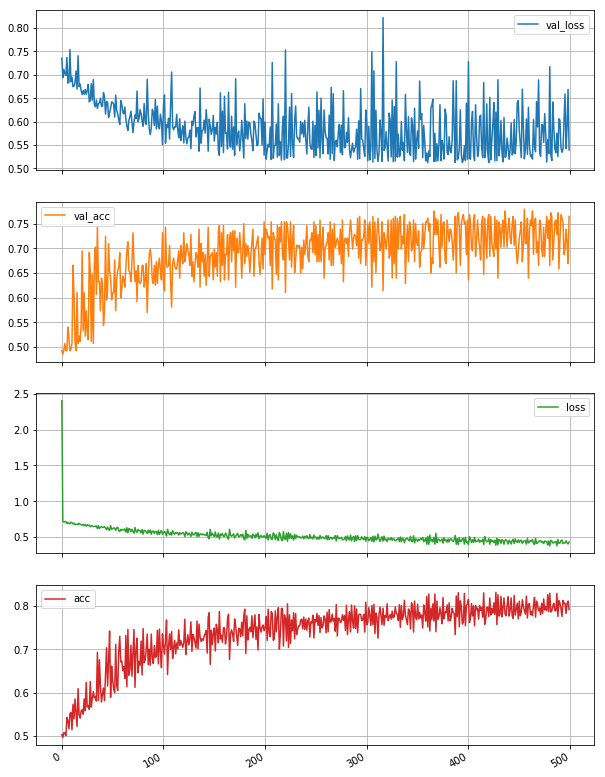

In [659]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

#### Evaluation

In [36]:
scores = model.evaluate(gs_test_features, gs_test_target)
# print("\nBinary Crossentropy %s: %.2f%%" % (model.metrics_names[0], scores[0]))
print("\nGSC Feature Subtraction - Neural Network Implementation \n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 51us/step

GSC Feature Subtraction - Neural Network Implementation 
acc: 62.05%


### 4. GSC DATASET WITH FEATURE CONCATENATION

In [560]:
### Fetch and Prepare Datasets
RawTarget = GetTargetVector('gsc_concat_t.csv')
RawData   = GenerateRawData('gsc_concat_X.csv',IsSynthetic)

### Prepare Training Data
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

### Prepare Validation Data
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

### Prepare Test Data
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(2417,)
(1024, 2417)
(302,)
(1024, 302)
(302,)
(1024, 302)


### 4A. Linear Regression With Gradient Descent  (GSC Feature Concatenation)

In [427]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=12).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [428]:
print ('----------Gradient Descent Solution--------------------')
print ("M = " + str(M))
print("Lambda = " + str(La/np.subtract(xn, x1))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 64
Lambda = 0.0390625
eta = 0.01
E_rms Training   = 0.67724
E_rms Validation = 0.70551
E_rms Testing    = 0.68659


### 4B. Logistic Regression with Gradient Descent  (GSC Feature Concatenation)

In [561]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #Creating M number of clusters using K-means
Mu = kmeans.cluster_centers_ #### Coordinates of cluster centers

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


W_Now        = np.dot(0, W) #random initialization, change 220 and see the accuracies
# when weights are already low, regularizer will decrease their effect even more and the fit will be very poor
#higher weights = better fit
La           = 10
learningRate = .01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Acc_TR = []
L_Acc_Val = []
L_Acc_Test = []
x1 = 0;
xn = 256; 

for i in range(x1,xn): #choose different number of samples and measure the erms, plot between them
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) #adding regularizer
    Delta_W       = -np.dot(learningRate,Delta_E) #multiplying with learning rate
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    L_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Acc_Test.append(float(Erms_Test.split(',')[0]))

In [562]:
print ('----------Logistic Regression using Stochastic Gradient Descent--------------------')
print ("M = " + str(M))
print("Lambda = " + str(np.around((La/np.subtract(xn, x1)), decimals = 5))) # lambda is La/no. of samples
print("eta = " + str(learningRate))
print ("Cross-Entropy Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Cross-Entropy Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Cross-Entropy Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Logistic Regression using Stochastic Gradient Descent--------------------
M = 10
Lambda = 0.03906
eta = 0.01
Cross-Entropy Training   = 0.69324
Cross-Entropy Validation = 0.72091
Cross-Entropy Testing    = 0.70322


### 4C. Neural Network Implementation  (GSC Feature Concatenation)

In [39]:
# Human Observed Dataset with Subtraction
# gs = gsc_sub.drop(['img_id_A', 'img_id_B'], axis = 1)
gc = pd.concat([gsc_concat_f_dirty, gsc_concat['target']], axis = 1) 
train, test = train_test_split(gc, test_size=0.1) #splitting to training and testing data

# Training Data
gc_train_target = train['target']
gc_train_features = train.drop(['target'], axis = 1)

# Testing Data
gc_test_target = test['target']
gc_test_features = test.drop(['target'], axis = 1)

print("gc_train_target shape is: " + str(gc_train_target.shape))
print("gc_train_features shape is: " + str(gc_train_features.shape))
print("gc_test_target shape is: " + str(gc_test_target.shape))
print("gc_test_features shape is: " + str(gc_test_features.shape))

gc_train_target shape is: (2718,)
gc_train_features shape is: (2718, 1024)
gc_test_target shape is: (303,)
gc_test_features shape is: (303, 1024)


In [45]:
K.clear_session()
model = Sequential()
model.add(Dense(256, input_dim = 1024, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('RMSprop', 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(gc_train_features, gc_train_target,
                    validation_split = 0.1,
                    batch_size = 256,
                    epochs = 500,
                    verbose = 0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018E893D4C88>,
      dtype=object)

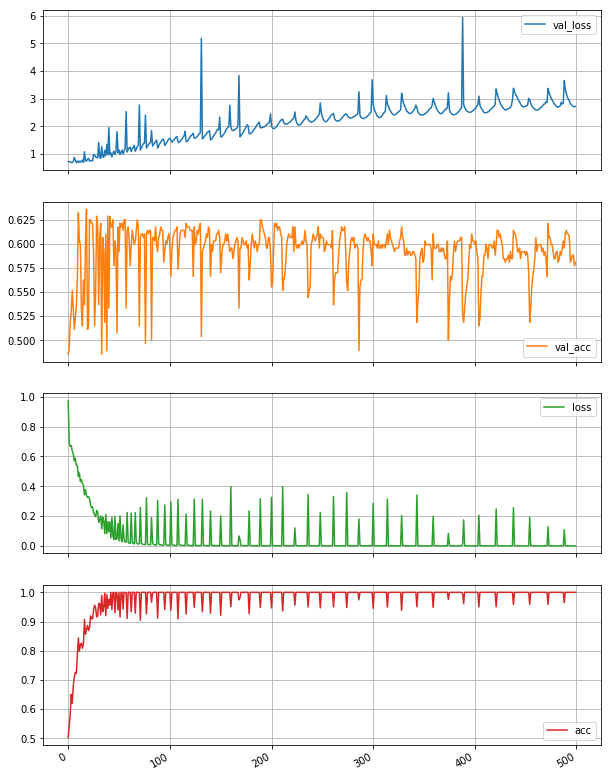

In [46]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

#### Evaluation

In [47]:
scores = model.evaluate(gc_test_features, gc_test_target)
# print("\nBinary Crossentropy %s: %.2f%%" % (model.metrics_names[0], scores[0]))
print("\nGSC Feature Subtraction - Neural Network Implementation \n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 56us/step

GSC Feature Subtraction - Neural Network Implementation 
acc: 64.69%
